#### **_Verifying Azure-ai-ml_**

In [1]:
pip show azure-ai-ml

Name: azure-ai-ml
Version: 1.20.0
Summary: Microsoft Azure Machine Learning Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python
Author: Microsoft Corporation
Author-email: azuresdkengsysadmins@microsoft.com
License: MIT License
Location: /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages
Requires: azure-common, azure-core, azure-mgmt-core, azure-storage-blob, azure-storage-file-datalake, azure-storage-file-share, colorama, isodate, jsonschema, marshmallow, msrest, opencensus-ext-azure, opencensus-ext-logging, pydash, pyjwt, pyyaml, strictyaml, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


#### **_Connecting to the workspace_**

In [2]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [3]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

Found the config file in: /config.json


#### **_Importing Libraries_**

In [4]:
pip install ipywidgets seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import pickle
import ipywidgets as widgets
from ipywidgets import interactive

import warnings
warnings.filterwarnings('ignore')

#### **_Loading the Dataset_**

In [2]:
df = pd.read_csv("./src/cardetailsv4.csv")

#### **_Data Insights_**

In [3]:
df.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


In [4]:
df.tail()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
2054,Mahindra,XUV500 W8 [2015-2017],850000,2016,90300,Diesel,Manual,Surat,White,First,Individual,2179 cc,138 bhp @ 3750 rpm,330 Nm @ 1600 rpm,FWD,4585.0,1890.0,1785.0,7.0,70.0
2055,Hyundai,Eon D-Lite +,275000,2014,83000,Petrol,Manual,Ahmedabad,White,Second,Individual,814 cc,55 bhp @ 5500 rpm,75 Nm @ 4000 rpm,FWD,3495.0,1550.0,1500.0,5.0,32.0
2056,Ford,Figo Duratec Petrol ZXI 1.2,240000,2013,73000,Petrol,Manual,Thane,Silver,First,Individual,1196 cc,70 bhp @ 6250 rpm,102 Nm @ 4000 rpm,FWD,3795.0,1680.0,1427.0,5.0,45.0
2057,BMW,5-Series 520d Luxury Line [2017-2019],4290000,2018,60474,Diesel,Automatic,Coimbatore,White,First,Individual,1995 cc,188 bhp @ 4000 rpm,400 Nm @ 1750 rpm,RWD,4936.0,1868.0,1479.0,5.0,65.0
2058,Mahindra,Bolero Power Plus ZLX [2016-2019],670000,2017,72000,Diesel,Manual,Guwahati,White,First,Individual,1493 cc,70 bhp @ 3600 rpm,195 Nm @ 1400 rpm,RWD,3995.0,1745.0,1880.0,7.0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                2059 non-null   object 
 1   Model               2059 non-null   object 
 2   Price               2059 non-null   int64  
 3   Year                2059 non-null   int64  
 4   Kilometer           2059 non-null   int64  
 5   Fuel Type           2059 non-null   object 
 6   Transmission        2059 non-null   object 
 7   Location            2059 non-null   object 
 8   Color               2059 non-null   object 
 9   Owner               2059 non-null   object 
 10  Seller Type         2059 non-null   object 
 11  Engine              1979 non-null   object 
 12  Max Power           1979 non-null   object 
 13  Max Torque          1979 non-null   object 
 14  Drivetrain          1923 non-null   object 
 15  Length              1995 non-null   float64
 16  Width 

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,2059.0,1.702992e+06,2.419881e+06,49000.0,484999.00,825000.0,1925000.0,35000000.0
Year,2059.0,2.016425e+03,3.363564e+00,1988.0,2014.00,2017.0,2019.0,2022.0
Kilometer,2059.0,5.422471e+04,5.736172e+04,0.0,29000.00,50000.0,72000.0,2000000.0
Length,1995.0,4.280861e+03,4.424585e+02,3099.0,3985.00,4370.0,4629.0,5569.0
Width,1995.0,1.767992e+03,1.352658e+02,1475.0,1695.00,1770.0,1831.5,2220.0
Height,1995.0,1.591735e+03,1.360740e+02,1165.0,1485.00,1545.0,1675.0,1995.0
Seating Capacity,1995.0,5.306266e+00,8.221701e-01,2.0,5.00,5.0,5.0,8.0
Fuel Tank Capacity,1946.0,5.200221e+01,1.511020e+01,15.0,41.25,50.0,60.0,105.0


In [7]:
df.shape

(2059, 20)

In [8]:
df.columns

Index(['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine',
       'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity'],
      dtype='object')

In [9]:
# Code to find the numeric columns in the dataset
numeric_columns = df.select_dtypes(include=['number']).columns
numeric_columns

Index(['Price', 'Year', 'Kilometer', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity'],
      dtype='object')

In [10]:
# Code to find the categorical columns in the dataset
categorical_columns = df.select_dtypes(exclude=['number']).columns
categorical_columns

Index(['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color',
       'Owner', 'Seller Type', 'Engine', 'Max Power', 'Max Torque',
       'Drivetrain'],
      dtype='object')

#### **_Cleaning And Preprocessing_**

##### **_Data Transformation_**

In [11]:
# Split `Max Power` and `Max Torque` into separate components
df[['Max Power Value', 'Max Power RPM']] = df['Max Power'].str.extract(r'(\d+\.?\d*) bhp @ (\d+ rpm)')

# Extract 'Max Torque Value' and 'Max Torque RPM' from 'Max Torque'
df[['Max Torque Value', 'Max Torque RPM']] = df['Max Torque'].str.extract(r'(\d+\.?\d*) Nm @ (\d+ rpm)')
# Clean 'Max Torque' column by extracting numeric values
df['Max Torque'] = df['Max Torque'].str.extract('(\d+)', expand=False).astype(float)

# Convert extracted values to numeric
df['Max Power Value'] = pd.to_numeric(df['Max Power Value'])
df['Max Torque Value'] = pd.to_numeric(df['Max Torque Value'])

# Extract numeric engine size from the 'Engine' column
df['Engine Size'] = df['Engine'].str.extract('(\d+)', expand=False).astype(float)
# Convert 'Engine Size' to numeric for analysis
df['Engine Size'] = pd.to_numeric(df['Engine Size'])

In [12]:
# Drop the old columns
df = df.drop(columns=['Engine', 'Max Power', 'Max Torque'])

In [13]:
# Checking id there are any duplicate or missing values
df.isnull().sum()

Make                    0
Model                   0
Price                   0
Year                    0
Kilometer               0
Fuel Type               0
Transmission            0
Location                0
Color                   0
Owner                   0
Seller Type             0
Drivetrain            136
Length                 64
Width                  64
Height                 64
Seating Capacity       64
Fuel Tank Capacity    113
Max Power Value       212
Max Power RPM         212
Max Torque Value      208
Max Torque RPM        208
Engine Size            80
dtype: int64

From the above, we can see that there are no duplicate values. But we have nearly 750 missing values.

##### **_Handling Missing values_**

In [14]:
# 1. Impute Numeric Columns (Median/Mean)
numeric_columns = ['Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity', 'Max Power Value', 'Max Torque Value', 'Engine Size']
for col in numeric_columns:
    df[col].fillna(df[col].median(), inplace=True)

In [15]:
# 2. Impute Categorical Columns (Mode or Predictive Imputation)
categorical_columns = ['Drivetrain', 'Max Power RPM', 'Max Torque RPM']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [16]:
# 3. Drop Drivetrain Column if Needed
if df['Drivetrain'].isnull().sum() / len(df) > 0.3:  # Threshold > 30% missing values
    df.drop(columns=['Drivetrain'], inplace=True)

In [17]:
# Missing values after processing
df.isnull().sum()

Make                  0
Model                 0
Price                 0
Year                  0
Kilometer             0
Fuel Type             0
Transmission          0
Location              0
Color                 0
Owner                 0
Seller Type           0
Drivetrain            0
Length                0
Width                 0
Height                0
Seating Capacity      0
Fuel Tank Capacity    0
Max Power Value       0
Max Power RPM         0
Max Torque Value      0
Max Torque RPM        0
Engine Size           0
dtype: int64

In [18]:
# normalized Data
df.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,Max Power Value,Max Power RPM,Max Torque Value,Max Torque RPM,Engine Size
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,...,3990.0,1680.0,1505.0,5.0,35.0,87.0,6000 rpm,109.0000,4500 rpm,1198.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,...,3995.0,1695.0,1555.0,5.0,42.0,74.0,4000 rpm,190.0000,2000 rpm,1248.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,...,3585.0,1595.0,1550.0,5.0,35.0,79.0,6000 rpm,112.7619,4000 rpm,1197.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,...,3995.0,1745.0,1510.0,5.0,37.0,82.0,6000 rpm,113.0000,4200 rpm,1197.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,...,4735.0,1830.0,1795.0,7.0,55.0,148.0,3400 rpm,343.0000,1400 rpm,2393.0


#### **_Encoding the features_**

In [19]:
label_encoder = LabelEncoder()

for column in ['Owner', 'Transmission', 'Fuel Type', 'Color', 'Seller Type']:
    df[column] = label_encoder.fit_transform(df[column])

#### **_Statiscal Analysis_**

In [20]:
# Perform statistical analysis for each numeric column
for column in numeric_columns:
    # Measures of Central Tendency
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]

    # Measures of Spread
    std_dev = df[column].std()
    variance = df[column].var()
    data_range = df[column].max() - df[column].min()
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    # Distribution Analysis
    skewness_value = skew(df[column], nan_policy='omit')
    kurtosis_value = kurtosis(df[column], nan_policy='omit')

    # Display the results
    print(f"\nColumn: {column}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Variance: {variance}")
    print(f"Range: {data_range}")
    print(f"Interquartile Range (IQR): {iqr}")
    print(f"Skewness: {skewness_value}")
    print(f"Kurtosis: {kurtosis_value}")

    # Check for Normality (Optional): Test if data follows normal distribution using skewness and kurtosis
    if abs(skewness_value) < 1 and abs(kurtosis_value) < 3:
        print(f"Distribution of {column} appears to be approximately normal.")
    else:
        print(f"Distribution of {column} is not normal.")


Column: Length
Mean: 4283.631374453618
Median: 4370.0
Mode: 3995.0
Standard Deviation: 435.79912702109493
Variance: 189920.87911234843
Range: 2470.0
Interquartile Range (IQR): 634.0
Skewness: -0.0406194810165102
Kurtosis: -0.7563391021560917
Distribution of Length appears to be approximately normal.

Column: Width
Mean: 1768.0543953375425
Median: 1770.0
Mode: 1695.0
Standard Deviation: 133.14641156776764
Variance: 17727.96691337337
Range: 745.0
Interquartile Range (IQR): 136.0
Skewness: 0.3115962832745579
Kurtosis: 1.0165629940236762
Distribution of Width appears to be approximately normal.

Column: Height
Mean: 1590.2826614861583
Median: 1545.0
Mode: 1475.0
Standard Deviation: 134.1868747030534
Variance: 18006.11734257295
Range: 830.0
Interquartile Range (IQR): 187.0
Skewness: 0.8769856945023606
Kurtosis: 0.1437971407938079
Distribution of Height appears to be approximately normal.

Column: Seating Capacity
Mean: 5.296745993200583
Median: 5.0
Mode: 5.0
Standard Deviation: 0.811029471

#### **_Data Visualization_**

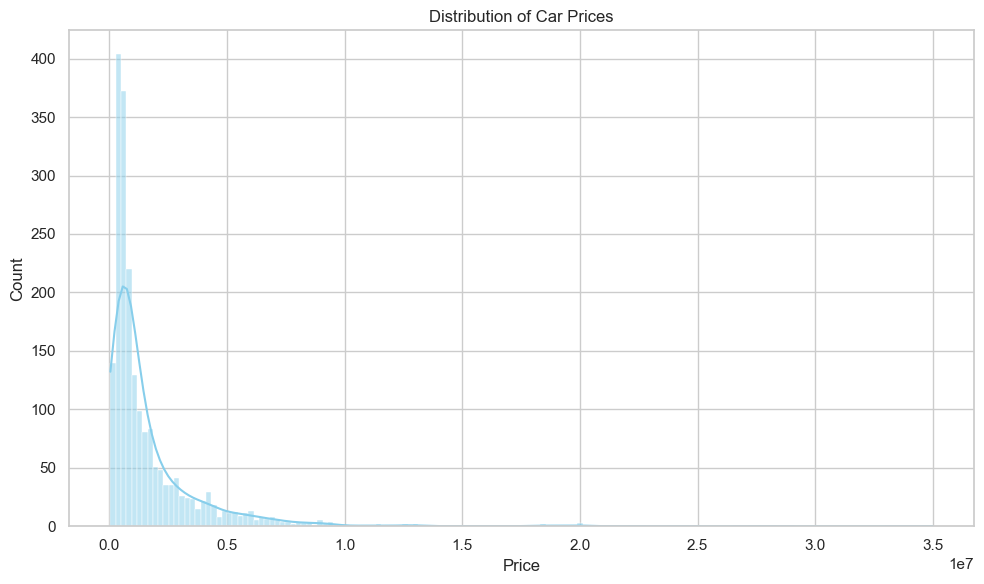

In [21]:
# Set up the plot style
sns.set(style="whitegrid")

# Plot 1: Histogram for 'Price'
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, color='skyblue')
plt.title('Distribution of Car Prices')

# Show the plot
plt.tight_layout()
plt.show()

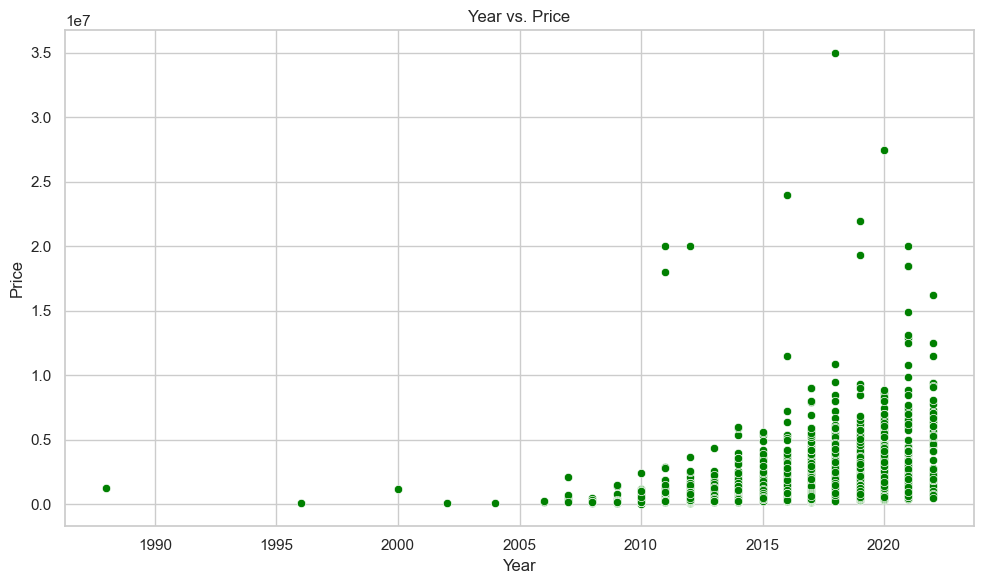

In [22]:
# Plot 3: Scatter plot for 'Year' vs. 'Price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Year'], y=df['Price'], color='green')
plt.title('Year vs. Price')

# Show the plot
plt.tight_layout()
plt.show()

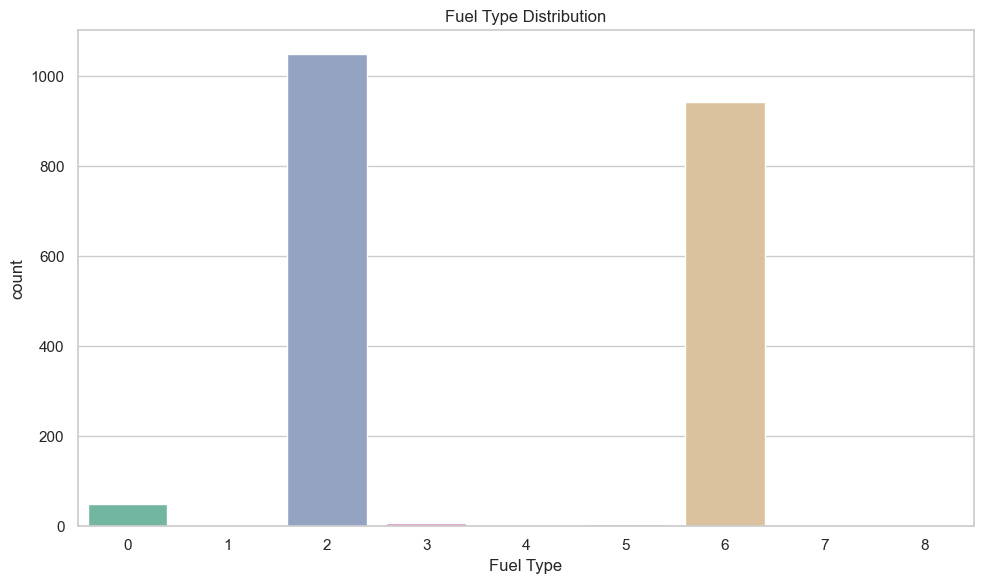

In [23]:
# Plot 4: Bar chart for 'Fuel Type'
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Fuel Type'], palette='Set2')
plt.title('Fuel Type Distribution')

# Show the plot
plt.tight_layout()
plt.show()

#### **_Feature Selection_**

In [24]:
# Create a copy of the dataframe to avoid modifying the original
df_encoded = df.copy()

# Encode all categorical columns
categorical_columns = df_encoded.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save encoders for potential inverse transformation

# Compute correlation matrix
correlation_matrix_all = df_encoded.corr()

# Extract correlations with 'Price'
correlations_with_price_all = correlation_matrix_all['Price'].sort_values(ascending=False)
correlations_with_price_all

Price                 1.000000
Max Power Value       0.780720
Max Torque Value      0.671969
Engine Size           0.611275
Fuel Tank Capacity    0.560842
Width                 0.559786
Length                0.551212
Year                  0.311400
Height                0.076279
Owner                 0.029360
Seating Capacity     -0.036116
Make                 -0.038195
Seller Type          -0.070351
Model                -0.078589
Drivetrain           -0.089471
Location             -0.115359
Fuel Type            -0.128157
Color                -0.128890
Kilometer            -0.150825
Max Power RPM        -0.169271
Max Torque RPM       -0.289064
Transmission         -0.476843
Name: Price, dtype: float64

<Axes: >

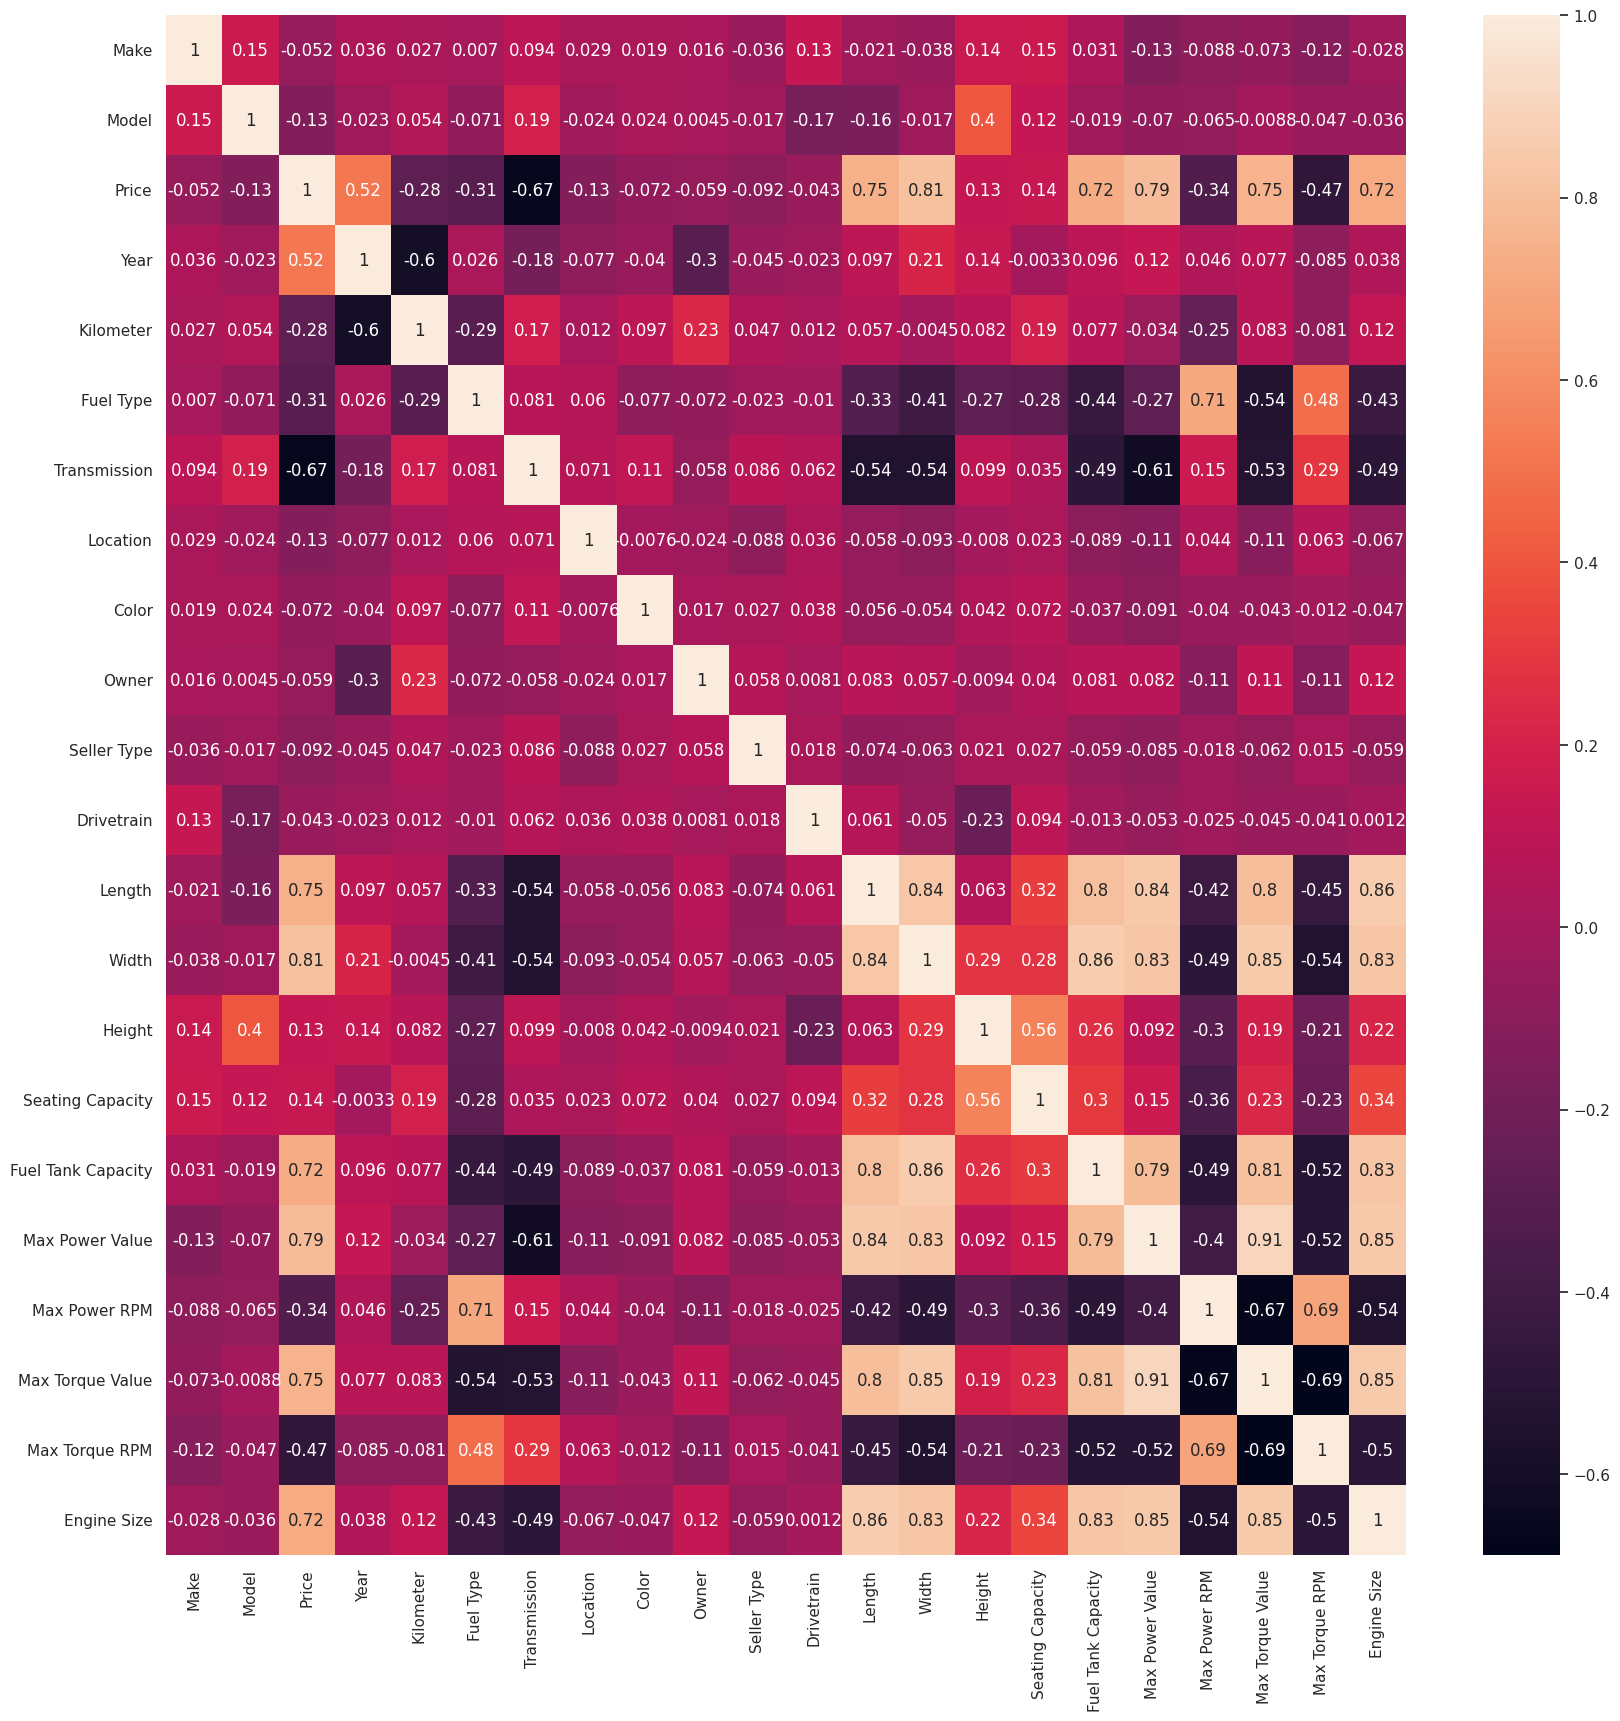

In [31]:
c=df_encoded.corr(method='spearman')
plt.figure(figsize=(20,20))
sns.heatmap(c,annot=True)

In [25]:
# Select the specified features
features = ['Max Power Value', 'Max Torque Value', 'Fuel Tank Capacity',
           'Width', 'Length', 'Year', 'Engine Size']
target = 'Price'

In [26]:
# Prepare features (X) and target (y)
X = df[features]
y = df[target]

#### **_Splitting the Dataset_**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **_Scaling the features_**

In [28]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### **_Training the Regression model_**

In [29]:
# Create and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

#### **_Making Predictions_**

In [30]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [31]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [32]:
print(f"R^2 Score: {r2}")

R^2 Score: 0.7121244451382218


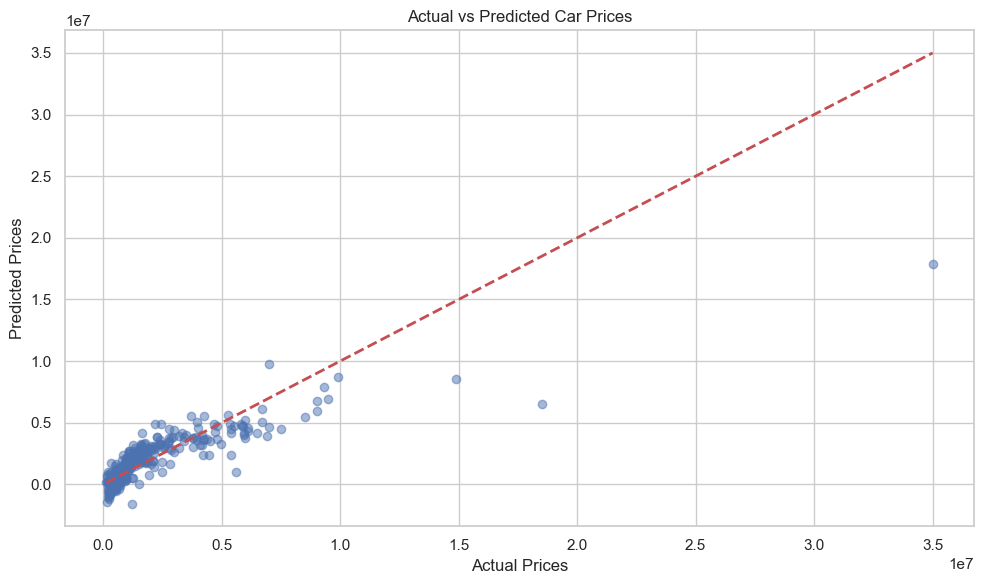

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Car Prices")
plt.tight_layout()
plt.show()

#### **_Using Cross-Validation_**

##### **_K-Fold Cross Validation_**

In [35]:
# Define k-fold cross-validation (e.g., 5 splits)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Apply cross-validation with R² scoring
cv_r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
cv_mse_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')  # Negative MSE for consistency

# Print results
print("Cross-Validation Results:")
print(f"Mean R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")

Cross-Validation Results:
Mean R²: 0.6640 ± 0.1054


In [36]:
model.fit(X, y)
y_pred = model.predict(X)

# Evaluate the model on the entire dataset
final_mse = mean_squared_error(y, y_pred)
final_r2 = r2_score(y, y_pred)

print("\nModel Performance on CV:")
print(f"Final R² Score: {final_r2:.4f}")


Model Performance on CV:
Final R² Score: 0.6759


#### **_Using Random Forest with CV_**

In [37]:
# CV: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_r2_scores = cross_val_score(rf_model, X, y, cv=kfold, scoring='r2')

print("\nModel (Random Forest):")
print(f"Mean R²: {rf_r2_scores.mean():.4f} ± {rf_r2_scores.std():.4f}")


Model (Random Forest):
Mean R²: 0.8796 ± 0.0468


#### **_Using Feature Engineering to enhance the performance of the models_**

In [38]:
# Applying Polynomial Feature Engineering on X (Faetures)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

##### **_Using Linear Regression, Random Forest, Gradient Boosting as models_**

In [39]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [40]:
# Function to evaluate model performance
def evaluate_model(model, X, y, kfold):
    cv_r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    cv_mse_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')  # Negative MSE
    return cv_r2_scores, cv_mse_scores

In [41]:
# Evaluate models
results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} with Polynomial Features...")
    r2_scores, mse_scores = evaluate_model(model, X_poly, y, kfold)
    results[model_name] = {
        "Mean R²": r2_scores.mean(),
        "R² Std": r2_scores.std(),
        "Mean MSE": mse_scores.mean(),
        "MSE Std": mse_scores.std()
    }
    print(f"{model_name} Mean R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")


Evaluating Linear Regression with Polynomial Features...
Linear Regression Mean R²: 0.7863 ± 0.0638

Evaluating Random Forest with Polynomial Features...
Random Forest Mean R²: 0.8555 ± 0.0625

Evaluating Gradient Boosting with Polynomial Features...
Gradient Boosting Mean R²: 0.8664 ± 0.0575


#### **_Training on full dataset_**

In [42]:
final_results = {}
for model_name, model in models.items():
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    final_mse = mean_squared_error(y, y_pred)
    final_r2 = r2_score(y, y_pred)
    final_results[model_name] = {
        "Final R²": final_r2,
        "Final MSE": final_mse
    }

#### **_Comparing the performance_**

In [43]:
print("\nFinal Model Performance (on Full Data):")
for model_name, result in final_results.items():
    print(f"{model_name} - Final R²: {result['Final R²']:.4f}")


Final Model Performance (on Full Data):
Linear Regression - Final R²: 0.8368
Random Forest - Final R²: 0.9733
Gradient Boosting - Final R²: 0.9667


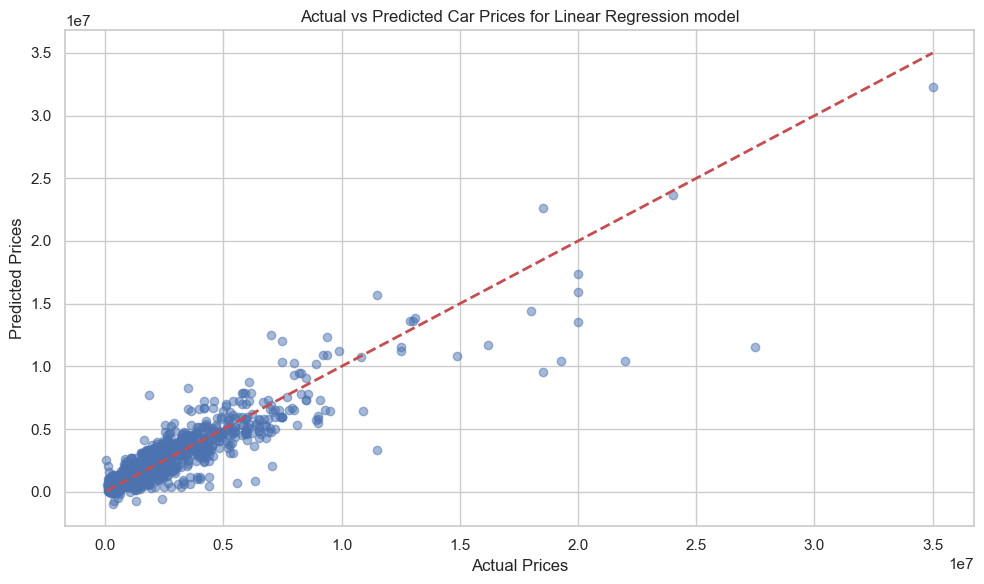

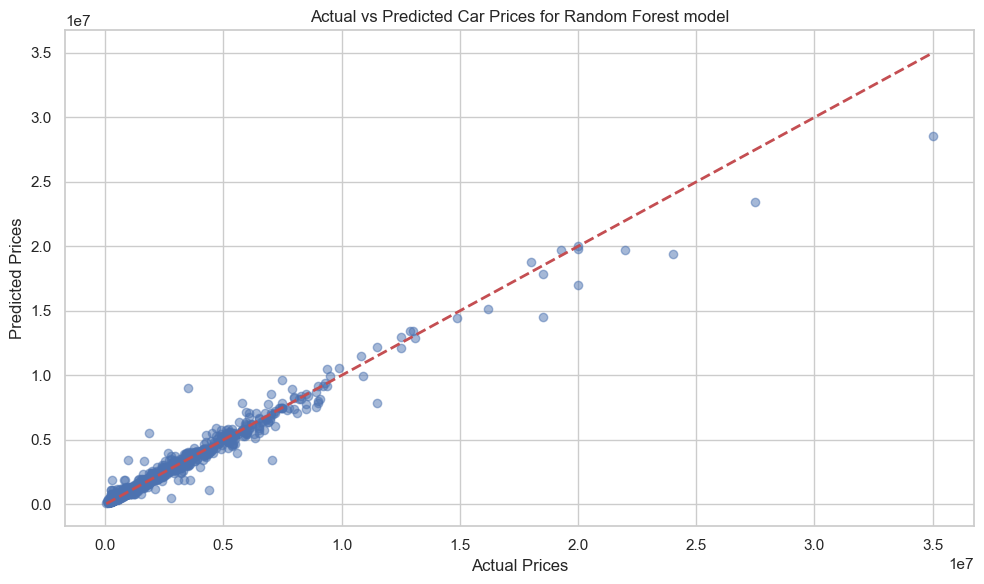

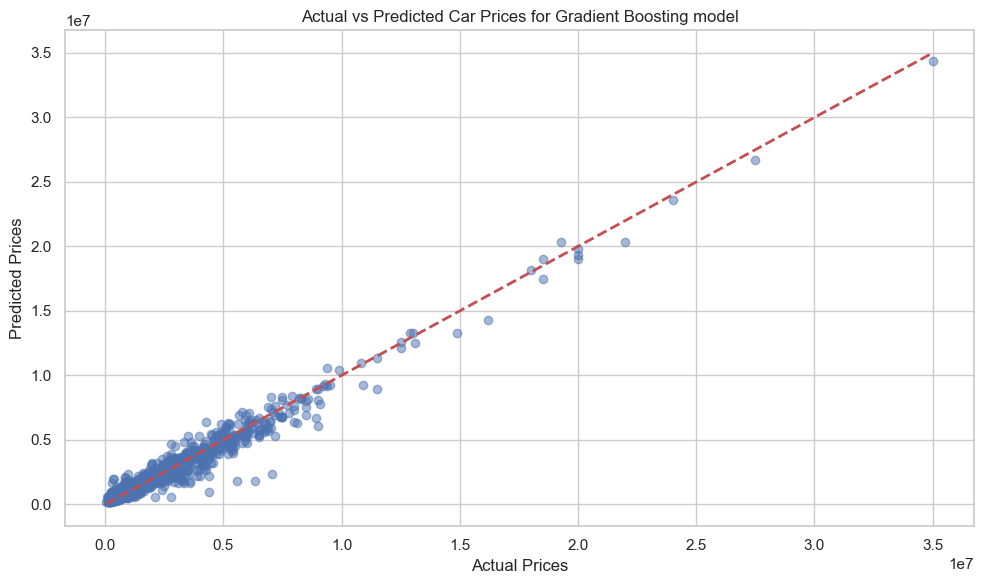

In [44]:
final_results = {}
for model_name, model in models.items():
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    final_mse = mean_squared_error(y, y_pred)
    final_r2 = r2_score(y, y_pred)
    final_results[model_name] = {
        "Final R²": final_r2,
        "Final MSE": final_mse
    }
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"Actual vs Predicted Car Prices for {model_name} model")
    plt.tight_layout()
    plt.show()